<a href="https://colab.research.google.com/github/PoseidonGames/bitburner/blob/master/train_image_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# ===== CELL 1: Setup ===== DO NOT RUN AGAIN OR YOU WILL OVERRIDE THE NEW IMAGES
!git clone https://github.com/Maknee/LeagueMinimapDetectionCNN.git
%cd LeagueMinimapDetectionCNN
!pip install torch torchvision opencv-python pillow matplotlib


Cloning into 'LeagueMinimapDetectionCNN'...
remote: Enumerating objects: 728, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 728 (delta 4), reused 9 (delta 4), pack-reused 719 (from 1)
Receiving objects: 100% (728/728), 72.89 MiB | 37.34 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/LeagueMinimapDetectionCNN


In [10]:
!pip install -q torch torchvision opencv-python pillow matplotlib

In [5]:
# ========================================
# CELL 2: Verify Installation and GPU
# ========================================
import torch
import torchvision
import cv2
import PIL
import matplotlib

print("✓ All packages imported successfully!\n")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("\n⚠️ WARNING: No GPU detected!")
    print("Go to: Runtime > Change runtime type > Select 'T4 GPU' > Save")
    print("Then re-run all cells")

✓ All packages imported successfully!

PyTorch Version: 2.9.0+cu126
Torchvision Version: 0.24.0+cu126
GPU Available: True
GPU Name: Tesla T4
GPU Memory: 15.83 GB


In [6]:
# ========================================
# CELL 3: Check GPU Availability
# ========================================
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ No GPU detected! Go to Runtime > Change runtime type > Select T4 GPU")


PyTorch Version: 2.9.0+cu126
GPU Available: True
GPU Name: Tesla T4
GPU Memory: 15.83 GB


In [11]:
# ========================================
# CELL 1B: Verify Directory and Files
# ========================================
import os

# Check current directory
print(f"Current directory: {os.getcwd()}\n")

# List files
print("Files in current directory:")
!ls -la

print("\n" + "="*60)

# Check if we're in the right place
if not os.path.exists('image_drawer.py'):
    print("❌ ERROR: image_drawer.py not found!")
    print("\nChanging to LeagueMinimapDetectionCNN directory...")
    %cd LeagueMinimapDetectionCNN
    print(f"New directory: {os.getcwd()}")
    !ls -la
else:
    print("✓ In correct directory")

print("="*60)

Current directory: /content/LeagueMinimapDetectionCNN

Files in current directory:
total 3104
drwxr-xr-x 7 root root    4096 Nov 28 21:40 .
drwxr-xr-x 1 root root    4096 Nov 28 21:40 ..
-rw-r--r-- 1 root root     339 Nov 28 21:40 capture_screenshot.py
drwxr-xr-x 5 root root    4096 Nov 28 21:40 evaluation
drwxr-xr-x 9 root root    4096 Nov 28 21:40 .git
-rw-r--r-- 1 root root      74 Nov 28 21:40 .gitattributes
-rw-r--r-- 1 root root       3 Nov 28 21:40 .gitignore
-rw-r--r-- 1 root root   40747 Nov 28 21:40 image_drawer.py
-rw-r--r-- 1 root root    3735 Nov 28 21:40 image_generator_dataset.py
drwxr-xr-x 6 root root    4096 Nov 28 21:40 league_icons
-rw-r--r-- 1 root root     695 Nov 28 21:40 pytorch_model.py
-rw-r--r-- 1 root root    5363 Nov 28 21:40 pytorch_test_ingame.py
-rw-r--r-- 1 root root    5266 Nov 28 21:40 pytorch_test_ingame_save_gif.py
-rw-r--r-- 1 root root    2325 Nov 28 21:40 README.md
drwxr-xr-x 2 root root    4096 Nov 28 21:40 repo_files
-rw-r--r-- 1 root root     2

/content/LeagueMinimapDetectionCNN
Generating sample training image...



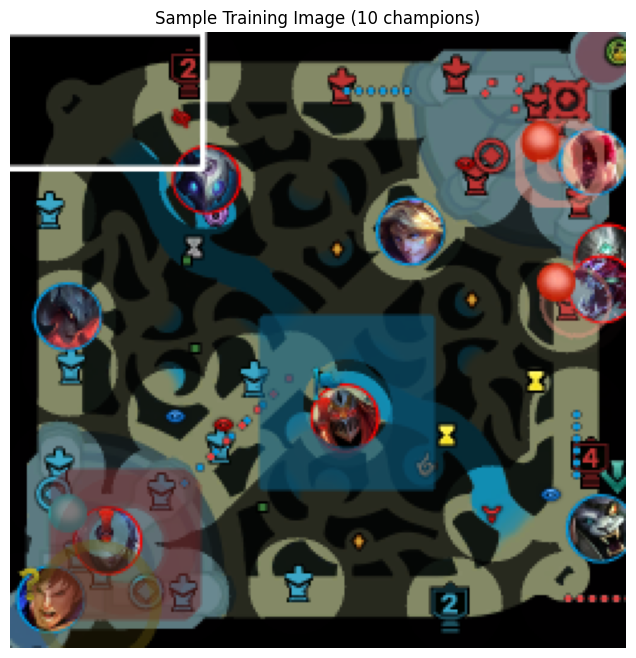

Champions: ezreal, garen, leesin, aatrox, rengar, aphelios, tryndamere, kindred, chogath, zed


In [12]:
# ========================================
# CELL 5: Test Image Generation (FIXED)
# ========================================
%cd /content/LeagueMinimapDetectionCNN

import torch
from image_drawer import ImageDrawer
import matplotlib.pyplot as plt
import numpy as np

print("Generating sample training image...\n")

icons_path = 'league_icons/'
image_drawer = ImageDrawer(
    icons_path + 'champions',
    icons_path + 'minimap',
    icons_path + 'fog',
    icons_path + 'misc',
    resize=(256, 256),
)

# Generate sample - CORRECT METHOD NAME
sample_img, sample_data = image_drawer.generate_data(0)

# Convert tensor to numpy for display
if isinstance(sample_img, torch.Tensor):
    sample_img_np = sample_img.permute(1, 2, 0).numpy()
else:
    sample_img_np = sample_img

# Display
plt.figure(figsize=(8, 8))
plt.imshow(sample_img_np)
plt.title(f"Sample Training Image ({len(sample_data['labels'])} champions)")
plt.axis('off')
plt.show()

champ_names = [image_drawer.id_to_champion[label.item()] for label in sample_data['labels']]
print(f"Champions: {', '.join(champ_names)}")

In [13]:
# ========================================
# CELL 6: Training Configuration
# ========================================
# Hyperparameters
num_classes = 172 + 1  # +1 for background
batch_size = 4
num_epochs = 50
learning_rate = 0.001
num_samples_per_epoch = 1000

print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
print(f"Number of classes:      {num_classes}")
print(f"Batch size:             {batch_size}")
print(f"Number of epochs:       {num_epochs}")
print(f"Learning rate:          {learning_rate}")
print(f"Samples per epoch:      {num_samples_per_epoch}")
print(f"\nEstimated time:         {num_epochs * 3 / 60:.1f} - {num_epochs * 5 / 60:.1f} hours")
print("=" * 60)

TRAINING CONFIGURATION
Number of classes:      173
Batch size:             4
Number of epochs:       50
Learning rate:          0.001
Samples per epoch:      1000

Estimated time:         2.5 - 4.2 hours


In [14]:
# ========================================
# CELL 7: Initialize Model (FIXED)
# ========================================
from pytorch_model import create_model
from image_generator_dataset import ImageGeneratorDataset
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

if not torch.cuda.is_available():
    print("⚠️ WARNING: Training on CPU will be VERY slow!")
    print("Enable GPU: Runtime > Change runtime type > T4 GPU\n")

# Create model
print("Creating Faster R-CNN model...")
model = create_model(num_classes, device)
model.to(device)
model.train()
print("✓ Model created\n")

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
print("✓ Optimizer configured\n")

# Dataset - FIXED: use 'dataset_length' instead of 'num_samples'
print("Setting up dataset...")
dataset = ImageGeneratorDataset(
    icons_path + 'champions',
    icons_path + 'minimap',
    icons_path + 'fog',
    icons_path + 'misc',
    dataset_length=num_samples_per_epoch,  # FIXED parameter name
    resize=(256, 256)
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)
print("✓ Dataset ready\n")

print("=" * 60)
print("READY TO TRAIN!")
print("=" * 60)

Using device: cuda

Creating Faster R-CNN model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


✓ Model created

✓ Optimizer configured

Setting up dataset...
✓ Dataset ready

READY TO TRAIN!


In [1]:
# ========================================
# CELL 7.5: Check for Existing Checkpoints & Resume
# ========================================
import glob
import os

# Find all checkpoint files
checkpoints = glob.glob('model_epoch_*.pth')
checkpoints.sort()

start_epoch = 0

if checkpoints:
    print("Found existing checkpoints:")
    for cp in checkpoints:
        print(f"  - {cp}")

    # Ask if you want to resume
    resume = input("\nResume from latest checkpoint? (yes/no): ").lower()

    if resume == 'yes' or resume == 'y':
        latest_checkpoint = checkpoints[-1]
        print(f"\nLoading checkpoint: {latest_checkpoint}")

        checkpoint = torch.load(latest_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']

        print(f"✓ Resumed from epoch {start_epoch}")
        print(f"  Previous loss: {checkpoint['loss']:.4f}")
    else:
        print("\nStarting fresh training...")
else:
    print("No checkpoints found. Starting fresh training...")

print(f"\nTraining will start from epoch {start_epoch + 1}")

No checkpoints found. Starting fresh training...

Training will start from epoch 1


In [4]:
# ========================================
# CELL 8: Training Loop (UPDATED - supports resume)
# ========================================
import time

print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)

num_epochs = 50

# Training loop - NOW STARTS FROM start_epoch
for epoch in range(start_epoch, num_epochs):
    epoch_start = time.time()
    model.train()
    epoch_loss = 0

    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")

    for batch_idx, (images, targets) in enumerate(dataloader):
        # Move to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Track loss
        epoch_loss += losses.item()

        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx+1}/{len(dataloader)} | Loss: {losses.item():.4f}")

    # Epoch summary
    avg_loss = epoch_loss / len(dataloader)
    epoch_time = time.time() - epoch_start

    print(f"\n✓ Epoch {epoch+1} Complete")
    print(f"  Average Loss: {avg_loss:.4f}")
    print(f"  Time: {epoch_time:.1f}s")

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f'model_epoch_{epoch+1}.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"  ✓ Checkpoint saved: {checkpoint_path}")

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)

# Save final model
final_model_path = 'league_minimap_detector_final.pth'
torch.save(model.state_dict(), final_model_path)
print(f"\n✓ Final model saved: {final_model_path}")

STARTING TRAINING


NameError: name 'model' is not defined